# Intuitive psychology meets intuitive physics

Inspired by: _Liu, S., Outa, J., & Akbiyik, S. (2024). Naive psychology depends on naive physics._

How do our systems of intuitive psychology and intuitive physics interoperate? In this notebook, I will show you how conceiving as these systems as domain-specific languages (DSLs) allows us to reason about interoperation in terms of application-programming interfaces (APIs) between DSLs — a problem that has been widely studied by programming language theorists over the past many decades. Specifically, I will draw on **memo**, a DSL for modeling psychology, and **jax2d**, a library/DSL for modeling physics, and show how they can be connected in a principled way to model classic inferences that even very young children make.

In [1]:
# memo, our psychology DSL
from memo import memo
import jax
import jax.numpy as np
from matplotlib import pyplot as plt

# jax2d, our physics DSL
from jax2d.engine import PhysicsEngine, create_empty_sim
from jax2d.scene import (add_circle_to_scene, add_rectangle_to_scene, add_thruster_to_scene)
from jax2d.sim_state import StaticSimParams, SimParams

To start, let us use jax2d to set up a simple physical world involving a circular agent who has to get to a goal. There may or may not be a fixed rectangular wall in between the agent and the goal. The agent can choose an angle $\theta$ (theta) and an impulse $\iota$ (iota) with which to launch itself towards its goal.

The details of this implementation are standard and not particularly interesting. But it is worth noting that this is completely modular within jax2d, the physics DSL: it does not require memo, the psychology DSL, at all.

In [2]:
static_sim_params = StaticSimParams(num_circles=2, num_polygons=6, num_thrusters=2)
engine = PhysicsEngine(static_sim_params)
step = jax.jit(engine.step)
sim_params = SimParams()
sim_state = create_empty_sim(static_sim_params, add_walls_and_ceiling=True, floor_offset=0.0)
sim_state, (_, body_idx) = add_circle_to_scene(
    sim_state, static_sim_params, position=np.array([0.0, 0.1]), radius=0.1, friction=0.0,
    velocity=np.array([0.0, 0.0]), density=1.0
)
ss0 = sim_state

def setup_sim(theta, iota, wall):
    sim_state = ss0
    if wall:
        sim_state, (_, wall_idx) = add_rectangle_to_scene(
            sim_state, static_sim_params, position=np.array([1., 0.5]), dimensions=np.array([0.1, 1.0]),
            fixated=True
        )
    sim_state, th_idx = add_thruster_to_scene(
        sim_state, body_idx,
        np.array([0, 0]),
        rotation=theta,
        power=iota
    )
    return sim_state

@jax.jit
def step_sim(t, sim_state):
    return step(
        sim_state, sim_params,
        np.array(
            [0.0] * static_sim_params.num_joints +
            [1.0 * (t == 0)] * static_sim_params.num_thrusters
        )
    )[0]

def run_sim(theta, iota, wall):
    sim_state = setup_sim(theta, iota, wall)
    sim_state = jax.lax.fori_loop(0, 100, step_sim, sim_state)
    return sim_state.circle.position[0]

def draw_sim(theta, iota, wall):  # for visualization only
    sim_state = setup_sim(theta, iota, wall)
    for t in range(100 + 1):
        sim_state = step_sim(t, sim_state)
        if t % 5 == 0:
            plt.gca().add_patch(
                plt.Circle(sim_state.circle.position[0], sim_state.circle.radius[0], alpha=0.25)
            )
    if wall:
        rect = sim_state.polygon.position[4] + sim_state.polygon.vertices[4]
        plt.plot(*(np.concatenate([rect, rect[0:1]])).T, c='k')
    plt.plot([0, 5], [0, 0], 'k')
    plt.axis('equal')
    plt.axis('off')
    plt.gca().add_patch(
        plt.Rectangle((2, 0), 3, 0.5, fc='green', alpha=0.25)
    )

Even in this simple world, we can set up a variety of interesting situations. Here are some combinations of high/low-effort actions, crossed against the presence/absence of a wall.

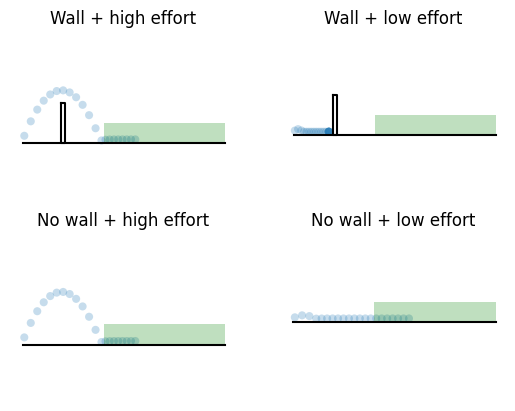

In [3]:
plt.subplot(2, 2, 1)
plt.title('Wall + high effort')
draw_sim(1.2, 1.0, True)

plt.subplot(2, 2, 2)
plt.title('Wall + low effort')
draw_sim(0., 0.2, True)

plt.subplot(2, 2, 3)
plt.title('No wall + high effort')
draw_sim(1.2, 1.0, False)

plt.subplot(2, 2, 4)
plt.title('No wall + low effort')
draw_sim(0., 0.5, False)

Now, let us model an inference studied by Csibra et al (2003): we will consider a baby who observes the trajectory taken by the agent, and model its expectations of whether or not the wall was present.

_Csibra, G., Bíró, S., Koós, O., & Gergely, G. (2003). One-year-old infants use teleological representations of actions productively. Cognitive Science, 27(1), 111–133._

First, we endow the agent with a utility, which is measured in terms of (a) a reward, determined by whether or not it reaches the goal area, and (b) a cost, determined by how much energy it expended, which is proportional to the impulse. We will balance these two terms according to some parameter `weight`. Notice that this "utility" function makes a _call_ to the jax2d physics simulation, though it itself is agnostic to how the simulation is carried out.

In [4]:
@jax.jit
def utility(theta, iota, wall, weight):
    def reward(xf, yf):
        return 1.0 * (xf > 2.0) * (yf < 0.5)
    cost = iota
    r1 = reward(*run_sim(theta, iota, wall=True))
    r0 = reward(*run_sim(theta, iota, wall=False))
    return weight * np.where(wall, r1, r0) - cost

Next, we will use memo to model a baby who observes an agent launch itself with parameters $(\theta, \iota)$, and model its surprisal at the presence of a wall as a function of $(\theta, \iota)$.

In [5]:
# Declare data types used in this model
Angle = np.linspace(0, np.pi / 2, 25)
Impulse = np.linspace(0, 1.5, 25)
Weight = np.linspace(0, 2, 5)
Wall = np.array([0, 1])

@memo
def model[theta: Angle, iota: Impulse]():
    baby: thinks[
        agent: given(wall in Wall, wpp=1),  # agent sees wall, hidden from baby
        agent: given(weight in Weight, wpp=1),  # agent has utility weight
        agent: chooses(  # agent chooses action
            theta in Angle, iota in Impulse,
            # The agent is softmax-optimal wrt the utility we defined.
            # Here, we make a call to `utility`, which in turn simulates
            # physics via jax2d.
            wpp=exp(3.0 * utility(theta, iota, wall, weight))
        )
    ]

    # baby makes an inference about wall after observing agent's action
    baby: observes [agent.theta] is theta
    baby: observes [agent.iota] is iota
    return baby[Pr[agent.wall == 1]]

Critically, the memo code is physics-agnostic. It reads as a model of psychology: it contains beliefs, desires, and rational actions. Physics is only referenced by way of the function `utility`, which (as previously discussed) makes a call to jax2d to run the simulation.

We can easily run this model and plot the results… (It takes a few seconds, which might seem slow, but remember that we are running the model across all $25\times25 = 625$ conditions!)

CPU times: user 1min 32s, sys: 2.9 s, total: 1min 34s
Wall time: 38.3 s


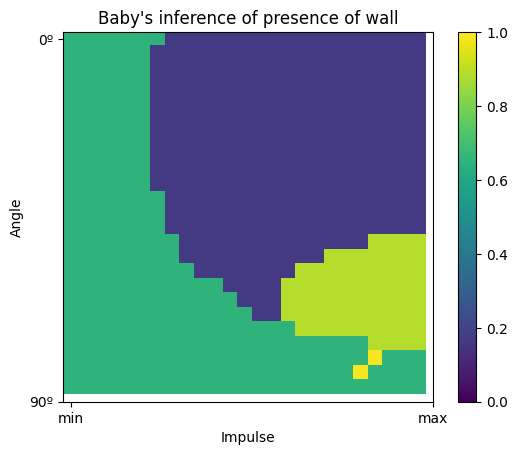

In [6]:
%%time
t = model()
plt.colorbar(plt.imshow(t, vmin=0, vmax=1))

plt.title("Baby's inference of presence of wall")

plt.xlabel('Impulse')
plt.xticks([0, 25], ['min', 'max'])

plt.ylabel('Angle')
plt.yticks([0, 25], ['0º', '90º'])

None

This plot shows three clear regimes of inference. What can we make of them?
1. The green left edge of the plot tells us that if the agent hardly moves, then the baby is unsure of the agent's intentions: it seems like the agent is not motivated to even try to reach the goal (perhaps because the goal weight is low). Similarly, if the agent launches itself straight up (close to 90º), then it is not clear what it is trying to do.
2. The yellow bottom-right corner tells us that if the agent launches itself at a steep angle, with a strong impulse, then the baby is highly confident that there is a wall present. This is the critical trial!
3. The blue top-right corner tells us that if the agent launches itself at a shallow angle, then no matter the impulse, the baby is confident that there is no wall present.

These inferences all accord with our intuitions, and the critical trial (2) also accords with Csibra et al's results.

## So what do we make of all this?

In this notebook, I showed you how to interface between memo, a DSL for modeling psychology, and jax2d, a DSL for modeling physics. We wrote programs in both of these DSLs, which operated independently, except that the memo program made a _call_ to the jax2d program in order to request simulations. In this way, we were able to integrate two modular systems to perform a joint computation — importantly, without resorting to any domain-general downstream processing unit to integrate computations from these two domain-specific systems. I think this is a plausible architecture for how systems of core knowledge interface with each other in the brain — and I hope we can find ways to test this idea further!